# **20230623**

## 20장 전이학습(transfer learning)

- 기존 이미지에서 학습한 정보를 가져와 내 프로젝트에 활용하는 것

- model.trainable 을 활용

- **모델 업데이트** : 기존 학습된 가중치를 재사용(False), 모델 추가(True) = **전이학습**


---

# **20230626**




### 01 소규모 데이터셋으로 만드는 강력한 학습 모델

- ImageDataGenerator() : 이미지 데이터의 수를 확장

```python

ImageDataGenerator(
                     rescale = 1./255       # minmax, 정규화
                    ,horizontal_flip=True   # 수평
                    ,width_shift_range=0.1  # 폭 조절
                    ,height_shift_range=0.1 # 높이 조절
                    ,rotation_range=5       # 회전
                    ,shear_range=0.7
                    ,zoom_range=1.2         # 확장
                    ,vertical_flip=True     # 수직
                    ,fill_mode='nearest
)
# object 생성
```


#### 실습 | 치매 환자의 뇌인지 일반인의 뇌인지 예측하기

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

In [16]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255
                                    ,horizontal_flip=True
                                    ,width_shift_range=0.1
                                    ,height_shift_range=0.1
                                    # 의료데이터는 flip,rotation,zoom하면 안됨
)

In [17]:
# 메모리상에 이미지가 추가되어 들어감
# flow_from_directory: 데이터가 있는 폴더의 위치
train_generator = train_datagen.flow_from_directory(
                '../data/train'          # (/ad, /normal)
                ,target_size=(150,150)   # 이미지 크기
                ,batch_size=5
                ,class_mode='binary'    # ad/normal 두가지 폴더=이진분류
)

Found 160 images belonging to 2 classes.


In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
test_generator = test_datagen.flow_from_directory(
                '../data/test'
                ,target_size=(150,150)
                ,batch_size=5
                ,class_mode='binary'
)

Found 120 images belonging to 2 classes.


In [20]:
# 모델 적용

model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_10 (Activation)  (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_11 (Activation)  (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                  

In [21]:
# 모델 실행 옵션 설정
model.compile(loss='binary_crossentropy'
             ,optimizer=optimizers.Adam(learning_rate=0.0002) # 보통 0.001 아래로 지정
             ,metrics=['accuracy']
             )

In [22]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10)

In [23]:
# 모델 실행
history = model.fit(
                    train_generator
                    ,epochs=100
                    ,validation_data=test_generator
                    ,validation_steps=10
                    , callbacks=[early_stopping_callback]
)

Epoch 1/100


32/32 [==============================] - 3s 79ms/step - loss: 0.6980 - accuracy: 0.5063 - val_loss: 0.6766 - val_accuracy: 0.6000
Epoch 2/100
32/32 [==============================] - 2s 70ms/step - loss: 0.6748 - accuracy: 0.5813 - val_loss: 0.6729 - val_accuracy: 0.5600
Epoch 3/100
32/32 [==============================] - 2s 74ms/step - loss: 0.6968 - accuracy: 0.5562 - val_loss: 0.6754 - val_accuracy: 0.5400
Epoch 4/100
32/32 [==============================] - 2s 74ms/step - loss: 0.6657 - accuracy: 0.6562 - val_loss: 0.6511 - val_accuracy: 0.6400
Epoch 5/100
32/32 [==============================] - 3s 78ms/step - loss: 0.6589 - accuracy: 0.5938 - val_loss: 0.6315 - val_accuracy: 0.7800
Epoch 6/100
32/32 [==============================] - 3s 78ms/step - loss: 0.6187 - accuracy: 0.6875 - val_loss: 0.5914 - val_accuracy: 0.7000
Epoch 7/100
32/32 [==============================] - 3s 77ms/step - loss: 0.6026 - accuracy: 0.6625 - val_loss: 0.5073 - val_accuracy: 0.8400
Epoch 8/100
32/32 

In [24]:
y_vloss = history.history['val_loss']
y_loss =  history.history['loss']

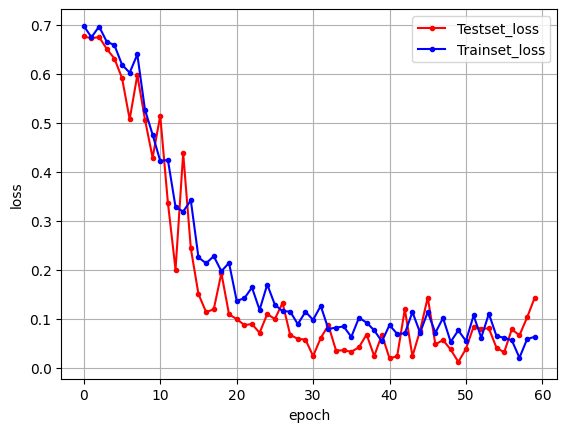

In [25]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.',c='red',label='Testset_loss')
plt.plot(x_len, y_loss, marker='.',c='blue',label='Trainset_loss')

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

### 02 전이 학습으로 모델 성능 극대화하기


- 전이학습 :  기존의 학습 결과(=weight)를 가져와 유사한 프로젝트에 사용하는 방법

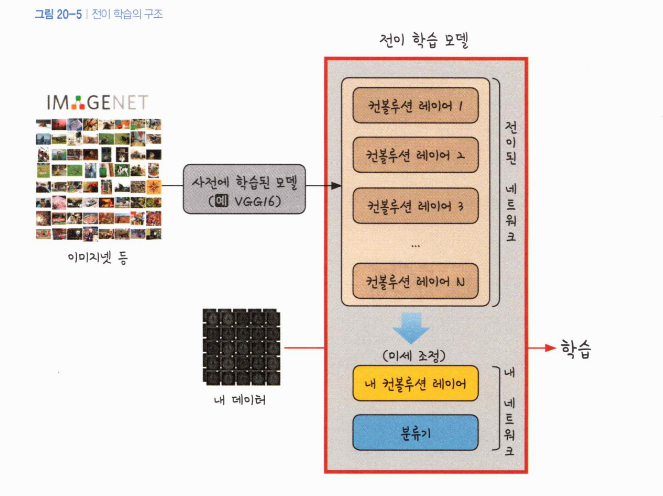

In [31]:
from IPython.display import Image
Image('./ch20_전이학습의 구조.png')

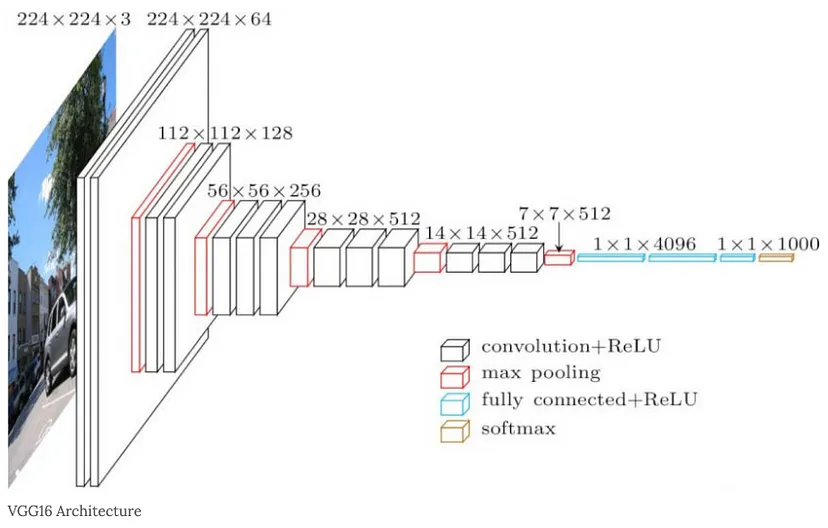

In [32]:
Image('./ch20_vgg16.png')

#### 실습 | 전이 학습 실습하기

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255
                                   ,horizontal_flip=True
                                   ,width_shift_range=0.1
                                   ,height_shift_range=0.1
                                   )

In [29]:
train_generator = train_datagen.flow_from_directory(

            '../data/train'
            ,target_size=(150,150)
            ,batch_size=5
            ,class_mode='binary'
)

Found 160 images belonging to 2 classes.


In [30]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
test_generator = test_datagen.flow_from_directory(

            '../data/test'
            ,target_size=(150,150)
            ,batch_size=5
            ,class_mode = 'binary'
)

Found 120 images belonging to 2 classes.


##### VGG16 모델

In [34]:
# include_top : 마지막 층 => 출력측 => 분류담당 => 불러올건지?말지?

transfer_model = VGG16(weights='imagenet'
                       ,include_top=False
                       ,input_shape=(150,150,3))

# 이미 있는 학습 가중치 사용 => False
transfer_model.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [38]:
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [35]:
finetune_model = models.Sequential()

finetune_model.add(transfer_model) # <- MaxPooling까지 들어와있는상태

# 이하 층에는 CNN 없음 
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))

# 출력층
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                524352    
                                                                 
 activation_15 (Activation)  (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
 activation_16 (Activation)  (None, 1)                

In [36]:
finetune_model.compile(loss='binary_crossentropy'
                       ,optimizer=optimizers.Adam(learning_rate=0.0002)
                       ,metrics=['accuracy'])

In [37]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10)

In [40]:
history = finetune_model.fit(
                            train_generator
                            ,epochs=20
                            ,validation_data=test_generator
                            ,validation_steps=10
                            ,callbacks=[early_stopping_callback]
)

Epoch 1/20
32/32 [==============================] - 14s 434ms/step - loss: 0.7313 - accuracy: 0.5125 - val_loss: 0.5427 - val_accuracy: 0.7400
Epoch 2/20
32/32 [==============================] - 15s 480ms/step - loss: 0.5134 - accuracy: 0.7875 - val_loss: 0.4808 - val_accuracy: 0.7800
Epoch 3/20
32/32 [==============================] - 17s 530ms/step - loss: 0.4991 - accuracy: 0.7688 - val_loss: 0.4603 - val_accuracy: 0.7600
Epoch 4/20
32/32 [==============================] - 17s 542ms/step - loss: 0.3998 - accuracy: 0.8687 - val_loss: 0.3203 - val_accuracy: 0.9200
Epoch 5/20
32/32 [==============================] - 17s 548ms/step - loss: 0.3690 - accuracy: 0.8813 - val_loss: 0.3514 - val_accuracy: 0.9200
Epoch 6/20
32/32 [==============================] - 17s 538ms/step - loss: 0.3112 - accuracy: 0.9062 - val_loss: 0.2615 - val_accuracy: 0.9000
Epoch 7/20
32/32 [==============================] - 19s 606ms/step - loss: 0.2712 - accuracy: 0.9125 - val_loss: 0.2480 - val_accuracy: 0.9400

In [41]:
y_vloss = history.history['val_loss']
y_loss =  history.history['loss']

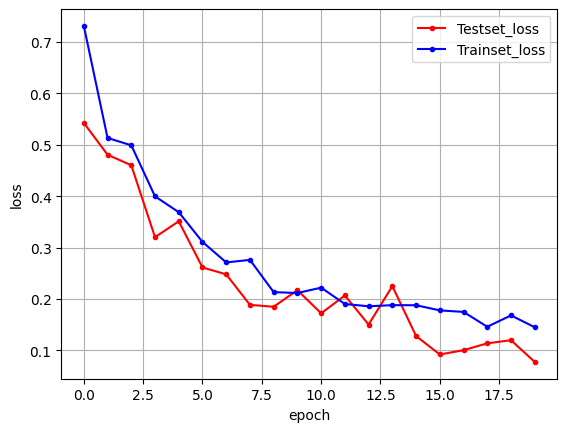

In [42]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.',c='red',label='Testset_loss')
plt.plot(x_len, y_loss, marker='.',c='blue',label='Trainset_loss')

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

##### 결론

안정적인 시작의 정확도, 빨라진 학습속도, 안정적인 그래프의 변화 추이